## Assignment 3

### Part A3.1: Access PMU from python

* http://neocontra.blogspot.com/2013/05/user-mode-performance-counters-for.html
* https://www.cprogramming.com/tutorial/shared-libraries-linux-gcc.html
*https://stackoverflow.com/questions/3247373/how-to-measure-program-execution-time-in-arm-cortex-a8-processor/3250835#3250835

In [91]:
import ctypes

##### insmod CPUcntr.ko param_cpu_id=0

## # Import shared library

In [92]:
_libInC = ctypes.CDLL('./libPMULib.so')

In [93]:
counter = _libInC.my_init_counters(1,0)
print(counter)

1


In [94]:
a = _libInC.my_get_cyclecount()
print(a)

2122206028


### Part A3.2: Comparing and Gathering Data

In [95]:
import multiprocessing
import os
import time
import numpy as np
import math
import matplotlib.pyplot as plot
import statistics as stats
from multiprocessing import Process, Manager
from multiprocessing.managers import BaseManager

In [96]:
SUCCESS = 0
FAILURE = -1
CPU_FHz = 650000000 #650MHz
EN_DIV_COUNT = 29
NUM_TRIAL = 3

#### Standard error : The formula for standard deviation calculates the square root of the variance, while the 
formula for standard error calculates the standard deviation divided by the square root of the sample size.

In [97]:
class DataMetricsMngr:
    num_terms = 0
    term_iteration = 0
    cpu_cycle_time_list    = []
    cpu_cycle_time_mean    = []
    cpu_cycle_time_std_dev = []
    cpu_cycle_time_std_err = []
    python_time_list       = []
    python_time_mean       = []
    python_time_std_dev    = []
    python_time_std_err    = []
    
    def __init__(self, numCount, numIteration):
        self.num_terms          = numCount
        self.term_iteration     = numIteration
        for i in range(numCount):          # A for loop for row entries
            a =[]
            for j in range(numIteration):      # A for loop for column entries
                a.append(float(0))
            self.cpu_cycle_time_list.append(a)
            self.python_time_list.append(a)
            self.cpu_cycle_time_mean.append(float(0))
            self.cpu_cycle_time_std_dev.append(float(0))
            self.cpu_cycle_time_std_err.append(float(0))
            self.python_time_mean.append(float(0))
            self.python_time_std_dev.append(float(0))
            self.python_time_std_err.append(float(0))
        print(len(self.cpu_cycle_time_list))
                
    def DataMetricsMngr_update_cpu_cycle_time_list(self,_index, cpu_cycle_time, num_iteration):
        self.cpu_cycle_time_list[_index][num_iteration] = cpu_cycle_time
        print("Cpu list {}".format(self.cpu_cycle_time_list[_index][num_iteration]))
        print("Cpu val {}".format(cpu_cycle_time))
        
    def DataMetricsMngr_update_python_time_list(self, _index, cpu_cycle_time, num_iteration):
        self.python_time_list[_index][num_iteration] = cpu_cycle_time
    
    def DataMetricsMngr_update_cpu_cycle_time_mean(self, _index):
        self.cpu_cycle_time_mean[_index] = round(stats.mean(self.cpu_cycle_time_list[_index]),6)
        print("Cpu Mean for {} = {}".format(_index, self.cpu_cycle_time_mean[_index]))
    
    def DataMetricsMngr_update_python_time_mean(self, _index):
        self.python_time_mean[_index] = round(stats.mean(self.python_time_list[_index]),6)
        print("Python Mean for {} = {}".format(_index, self.python_time_mean[_index]))
    
    def DataMetricsMngr_update_cpu_cycle_time_std_err(self, _index):
        #first find std dev
        self.cpu_cycle_time_std_dev[_index] = stats.stdev(self.cpu_cycle_time_list[_index], self.cpu_cycle_time_mean[_index])
        #find standard error
        self.cpu_cycle_time_std_err[_index] = self.cpu_cycle_time_std_dev[_index] / math.sqrt(self.term_iteration)
        print("CPU Standard error for index {} is {}".format(_index, self.cpu_cycle_time_std_err[_index]))
        
    def DataMetricsMngr_update_python_time_std_err(self, _index):
         #first find std dev
        self.python_time_std_dev[_index] = stats.stdev(self.python_time_list[_index], self.python_time_mean[_index])
        #find standard error
        self.python_time_std_err[_index] = self.python_time_std_dev[_index] / math.sqrt(self.term_iteration)
        print("Python Standard error for index {} is {}".format(_index, self.cpu_cycle_time_std_err[_index]))
        
    def DataMetricsMngr_plot_cpu_cycle_metrics(self):
        x = []
        for i in range(self.num_terms):
            x.append(i+1)
            
        plot.errorbar(x, self.cpu_cycle_time_mean, self.cpu_cycle_time_std_err, linestyle='solid', marker='^')
        plot.title("Plot of average cpu cycle time with error bars")
        plot.xlabel("Fibonacci Numbers")
        plot.ylabel("Average time with error")
        plot.show()
    
    def DataMetricsMngr_plot_python_cycle_metrics(self):
        x = []
        for i in range(self.num_terms):
            x.append(i+1)
            
        plot.errorbar(x, self.python_time_mean, self.python_time_std_err, linestyle='solid', marker='^')
        plot.title("Plot of average Python time with error bars")
        plot.xlabel("Fibonacci Numbers")
        plot.ylabel("Average time with error")
        plot.show()
    
    def DataMetricsMngr_print_all_mertics(self):
        print(self.cpu_cycle_time_list)
        print(self.python_time_list)
        print(self.cpu_cycle_time_mean)
        print(self.cpu_cycle_time_std_dev)
        print(self.cpu_cycle_time_std_err)
    
    
    

In [98]:
# Program to calculate the Fibonacci sequence up to n-th term
def recur_fibo(n):
    if n <= 1:
        return n
    else:
        return(recur_fibo(n-1) + recur_fibo(n-2))

In [99]:
def performance_metrics_calculator(_id, num_fib, b_reset, b_divide, num_iter, metricsMngr):
    #Assign the process to specific CPU
    os.system("taskset -pc {} {}".format(_id,os.getpid()))

    print("Fibonacci Series for num {}".format(num_fib))
    print("Reset {} Divide{}".format(b_reset, b_divide))
    MULT = 1
    if b_divide == True:
        MULT = 64
    i = 0
    while i <  num_iter:
        #init timers
        if b_divide == True:
            _libInC.my_init_counters(1, 1);
        else:
            _libInC.my_init_counters(1, 0);
    
        #take python module time
        tic = time.time()
    
        #get cycle count
        cpu_time1 = MULT* ctypes.c_uint32(_libInC.my_get_cyclecount()).value
    
        # Run recur fib program
        recur_fibo(num_fib)
    
        #get 2nd cycle count 
        cpu_time2 = MULT* ctypes.c_uint32(_libInC.my_get_cyclecount()).value
    
        #get 2nd timer
        tac = time.time()
    
        time_cycleCount = round(((cpu_time2-cpu_time1)/CPU_FHz),6)
        python_time = round((tac - tic),6)
        print("Trial {}".format(i+1))
        print("Timer module value ={} ".format(python_time))
        print("Cycle count value = {}".format(time_cycleCount))
        metricsMngr.DataMetricsMngr_update_cpu_cycle_time_list((num_fib-1),time_cycleCount,i)
        metricsMngr.DataMetricsMngr_update_python_time_list((num_fib-1),python_time,i)
        #metricsMngr.DataMetricsMngr_print_all_mertics()
        i +=1

In [100]:
def main():
    nterms = int(input("Enter terms till which Fibonacci series is to be generated? "))
    # check if the number of terms is valid
    if nterms <= 0:
        print("Please enter a positive integer")
        return FAILURE
    
    cpu_id = int(input("Enter CPU ID(0/1) for CPU selection"))
    print("CPU ID Entered = ", cpu_id)
    # check if cpu id is valid
    if cpu_id < 0 or cpu_id > 1:
        print("unsupported CPU id Entered")
        return FAILURE
    i = 1
    num_iteration = NUM_TRIAL

    # Referred this https://stackoverflow.com/questions/3671666/sharing-a-complex-object-between-processes
    
    BaseManager.register('DataMetricsMngr', DataMetricsMngr)
    manager = BaseManager()
    manager.start()
    metricsMngr = manager.DataMetricsMngr(nterms, num_iteration)

    while i <= nterms:
        do_reset = True
        do_divide = False
        if i > EN_DIV_COUNT:
            do_divide = True
        # create a process
        p1 = multiprocessing.Process(target=performance_metrics_calculator, args=(cpu_id,i,do_reset, do_divide, num_iteration, metricsMngr)) # the first arg defines which CPU to run the 'target' on
        # start the process
        p1.start() 
        p1Name = p1.name # get process1 name
        p1.join() # wait for process1 to finish
        #Update metrics for the new recorded item
        metricsMngr.DataMetricsMngr_update_cpu_cycle_time_mean(i-1)
        metricsMngr.DataMetricsMngr_update_python_time_mean(i-1)
        metricsMngr.DataMetricsMngr_update_cpu_cycle_time_std_err(i-1)
        metricsMngr.DataMetricsMngr_update_python_time_std_err(i-1)
        #metricsMngr.DataMetricsMngr_print_all_mertics()
        i +=1
        print('Process with name, {}, is finished'.format(p1Name))
    #plot the metrics
    metricsMngr.DataMetricsMngr_plot_cpu_cycle_metrics()
    metricsMngr.DataMetricsMngr_plot_python_cycle_metrics()
    #metricsMngr.DataMetricsMngr_print_all_mertics()

### Main function to handle input and spawn separate process

Enter terms till which Fibonacci series is to be generated? 35
Enter CPU ID(0/1) for CPU selection0
CPU ID Entered =  0
35
Fibonacci Series for num 1
Reset True DivideFalse
Trial 1
Timer module value =0.000218 
Cycle count value = 0.000101
Cpu list 0.000101
Cpu val 0.000101
Trial 2
Timer module value =5.4e-05 
Cycle count value = 2.7e-05
Cpu list 2.7e-05
Cpu val 2.7e-05
Trial 3
Timer module value =5.7e-05 
Cycle count value = 3.1e-05
Cpu list 3.1e-05
Cpu val 3.1e-05
Cpu Mean for 0 = 0.00011
Python Mean for 0 = 0.00011
CPU Standard error for index 0 is 5.417358930122481e-05
Python Standard error for index 0 is 5.417358930122481e-05
Process with name, Process-276, is finished
Fibonacci Series for num 2
Reset True DivideFalse
Trial 1
Timer module value =0.000767 
Cycle count value = 0.000629
Cpu list 0.000629
Cpu val 0.000629
Trial 2
Timer module value =5.7e-05 
Cycle count value = 3.1e-05
Cpu list 3.1e-05
Cpu val 3.1e-05
Trial 3
Timer module value =5.5e-05 
Cycle count value = 3e-05
Cpu 

Cpu val 0.002931
Trial 2
Timer module value =0.002762 
Cycle count value = 0.002735
Cpu list 0.002735
Cpu val 0.002735
Trial 3
Timer module value =0.002762 
Cycle count value = 0.002734
Cpu list 0.002734
Cpu val 0.002734
Cpu Mean for 14 = 0.00286
Python Mean for 14 = 0.00286
CPU Standard error for index 14 is 9.833333333333323e-05
Python Standard error for index 14 is 9.833333333333323e-05
Process with name, Process-290, is finished
Fibonacci Series for num 16
Reset True DivideFalse
Trial 1
Timer module value =0.004894 
Cycle count value = 0.004768
Cpu list 0.004768
Cpu val 0.004768
Trial 2
Timer module value =0.004447 
Cycle count value = 0.004418
Cpu list 0.004418
Cpu val 0.004418
Trial 3
Timer module value =0.004753 
Cycle count value = 0.00471
Cpu list 0.00471
Cpu val 0.00471
Cpu Mean for 15 = 0.004698
Python Mean for 15 = 0.004698
CPU Standard error for index 15 is 0.00013193559034619873
Python Standard error for index 15 is 0.00013193559034619873
Process with name, Process-291, i

Timer module value =2.268824 
Cycle count value = 2.268737
Cpu list 2.268737
Cpu val 2.268737
Cpu Mean for 28 = 2.269063
Python Mean for 28 = 2.269063
CPU Standard error for index 28 is 0.0006677737474457042
Python Standard error for index 28 is 0.0006677737474457042
Process with name, Process-304, is finished
Fibonacci Series for num 30
Reset True DivideTrue
Trial 1
Timer module value =3.665715 
Cycle count value = 3.665527
Cpu list 3.665527
Cpu val 3.665527
Trial 2
Timer module value =3.667062 
Cycle count value = 3.666964
Cpu list 3.666964
Cpu val 3.666964
Trial 3
Timer module value =3.665933 
Cycle count value = 3.665838
Cpu list 3.665838
Cpu val 3.665838
Cpu Mean for 29 = 3.666237
Python Mean for 29 = 3.666237
CPU Standard error for index 29 is 0.00041743755354678485
Python Standard error for index 29 is 0.00041743755354678485
Process with name, Process-305, is finished
Fibonacci Series for num 31
Reset True DivideTrue
Trial 1
Timer module value =5.929517 
Cycle count value = 5.92

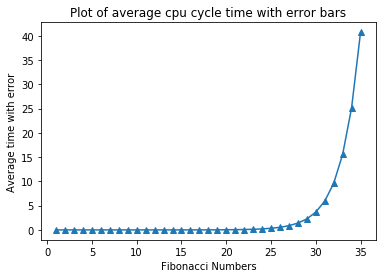

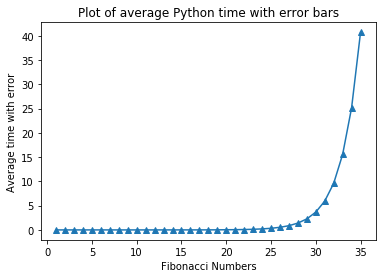

Program exited successfully


In [101]:
if __name__ == '__main__':
    result = main()
    if result == FAILURE:
        print("Program exited, exit code = FAILURE")
    else:
        print("Program exited successfully")